In [150]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [380]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoidDerivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def reluDerivative(x):
    return (x > 0).astype(float)

# dictionary to map out activation functions; used when I was testing various combinations of hidden layers
ACTIVATIONS = {
    "sigmoid": (sigmoid, sigmoidDerivative),
    "relu": (relu, reluDerivative),
}

def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

def binary_cross_entropyDerivative(y_true, y_pred):
    return (y_pred - y_true) / ((y_pred * (1 - y_pred)) + 1e-8)

# ridge penatly
def l2_penalty(weights, alpha=0.001):
    return alpha * sum(np.sum(w ** 2) for w in weights)

# main class, import for streamlit
class MLPBinaryClassifier:
    def __init__(self, input_size, hidden_layers, activations, 
                 dropout_rates=None, learning_rate=0.01, epochs=1000, l2_lambda=0.001):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.activations = activations
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l2_lambda = l2_lambda
        self.dropout_rates = dropout_rates if dropout_rates else [0.0] * len(hidden_layers)
        self.weights = []
        self.biases = []
        self.activation_funcs = []
        self.activation_derivatives = []
        self.train_losses = []
        self.val_losses = []
        self._initialize_network()

    def _initialize_network(self):
        layer_sizes = [self.input_size] + self.hidden_layers + [1]
        
        if len(self.activations) != len(layer_sizes) - 1:
            raise ValueError("# activation functions != # layers")

        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))

            activation_fn, activation_deriv = ACTIVATIONS[self.activations[i]]
            self.activation_funcs.append(activation_fn)
            self.activation_derivatives.append(activation_deriv)

    # feedforward
    def forward(self, X, training=False):
        activations = [X]
        dropout_masks = []
        
        A = X
        for i in range(len(self.weights)):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.activation_funcs[i](Z)

            if training and i < len(self.dropout_rates):
                rate = self.dropout_rates[i]
                if rate > 0:
                    mask = (np.random.rand(*A.shape) > rate).astype(float)
                    A *= mask
                    A /= (1 - rate)
                    dropout_masks.append(mask)
                else:
                    dropout_masks.append(None)
            else:
                dropout_masks.append(None)
                
            activations.append(A)

        return activations, dropout_masks

    # backpropagration
    def backward(self, activations, y, dropout_masks):
        grads_w = []
        grads_b = []
        
        delta = binary_cross_entropyDerivative(y, activations[-1]) * self.activation_derivatives[-1](activations[-1])

        for i in reversed(range(len(self.weights))):
            grads_w.insert(0, np.dot(activations[i].T, delta))
            grads_b.insert(0, np.sum(delta, axis=0, keepdims=True))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivatives[i - 1](activations[i])
                if dropout_masks[i - 1] is not None:
                    delta *= dropout_masks[i - 1]
                    
        return grads_w, grads_b

    def update_weights(self, grads_w, grads_b):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    # leave X_val and y_val alone if no validation needed
    def train(self, X, y, X_val=None, y_val=None):
        for epoch in range(self.epochs):
            activations, dropout_masks = self.forward(X, training=True)
            grads_w, grads_b = self.backward(activations, y, dropout_masks)
            self.update_weights(grads_w, grads_b)
            
            train_loss = binary_cross_entropy(y, activations[-1]) + l2_penalty(self.weights, self.l2_lambda)
            self.train_losses.append(train_loss)

            if X_val is not None and y_val is not None:
                val_preds = self.forward(X_val, training=False)[0][-1]
                val_loss = binary_cross_entropy(y_val, val_preds) + l2_penalty(self.weights, self.l2_lambda)
                self.val_losses.append(val_loss)
            
            if epoch % 100 == 0:
                loss = binary_cross_entropy(y, activations[-1]) + l2_penalty(self.weights, alpha=0.001)
                print(f"Epoch {epoch}, Loss: {loss}")
                if X_val is not None:
                    print(f"Val Loss = {val_loss}")

    def predict(self, X):
        return (self.forward(X)[0][-1] > 0.5).astype(int)

    # loss curve graph
    def loss(self):
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.legend()
        plt.show()

In [347]:
# test data
def test_data(model=model, df_input=pd.DataFrame(), X_input_test=None, y_input_test=None, scale=False):
    if not(df_input.empty):
        X_input_test = df_input.drop('class', axis=1)
        y_input_test = df_input['class'].values.reshape(-1, 1)
        
    if scale:
        X_input_test = scaler.fit_transform(X_input_test)
        
    y_input_pred = model.predict(X_input_test)
    accuracy = np.mean(y_input_pred == y_input_test)
    incorrect_idx = list(set(np.where(np.array(y_input_pred) != np.array(y_input_test))[0]))
    print("Accuracy: ", accuracy)
    print("Confusion Matrix: \n", confusion_matrix(y_input_test, y_input_pred))
    return y_input_pred, y_input_test, incorrect_idx

In [348]:
df = pd.read_csv('data/ckd_clean.csv')
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.000000,36.0,1.2,139.333333,4.600000,15.4,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,103.333333,18.0,0.8,141.000000,4.333333,11.3,38.0,6000.0,5.733333,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.000000,53.0,1.8,138.666667,4.866667,9.6,31.0,7500.0,2.833333,0.0,1.0,0.0,1.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,1.0,0.0,0.0,1.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.000000,26.0,1.4,138.666667,4.300000,11.6,35.0,7300.0,4.600000,0.0,0.0,0.0,0.0,0.0,0.0,1


In [349]:
X_df = df.drop(["class"], axis=1)

# X = X_df.values
y = df["class"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train.values)
X_scaled_test = scaler.transform(X_test.values)

X_scaled_train.shape, X_scaled_test.shape, y_train.shape, y_test.shape

((320, 24), (80, 24), (320, 1), (80, 1))

Epoch 0, Loss: 0.6932048792942246
Val Loss = 0.6541478273489089
Epoch 100, Loss: 0.14253880418402626
Val Loss = 0.08075466674644316
Epoch 200, Loss: 0.06955068506049542
Val Loss = 0.050434690432694246
Epoch 300, Loss: 0.08552407881286435
Val Loss = 0.05993672907389339
Epoch 400, Loss: 0.07047147038898
Val Loss = 0.08975009591699123
Epoch 500, Loss: 0.07472830459232468
Val Loss = 0.07715494555822186
Epoch 600, Loss: 0.08779435477190056
Val Loss = 0.0954954055185755
Epoch 700, Loss: 0.07233395864600986
Val Loss = 0.07878136744075662
Epoch 800, Loss: 0.08038163675089394
Val Loss = 0.10392838546889538
Epoch 900, Loss: 0.07071398143367683
Val Loss = 0.10420865039161634


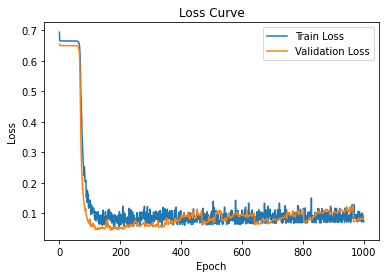

In [381]:
model = MLPBinaryClassifier(
    input_size=24,
    hidden_layers=[16, 8],
    activations=["relu", "relu", "sigmoid"],
    dropout_rates=[0.5, 0.5],
    learning_rate=0.01,
    epochs=1000,
    l2_lambda=0.001
)

model.train(X_scaled_train, y_train, X_val=X_scaled_test, y_val=y_test)
model.loss()

In [351]:
y_pred, y_test, incorrect_idx = test_data(model=model, X_input_test=X_scaled_test, y_input_test=y_test)

Accuracy:  0.9875
Confusion Matrix: 
 [[28  0]
 [ 1 51]]


In [357]:
X_test.iloc[incorrect_idx]

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia
209,19.0,70.0,1.02,0.0,0.0,0.0,0.0,0.0,0.0,146.0,35.666667,0.8,140.0,4.033333,11.5,43.333333,6900.0,5.266667,0.0,0.0,0.0,0.0,0.0,0.0


## Testing New Data

In [358]:
df_new = pd.read_csv('data/ckd_new.csv')
df_new.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,3,72.530698,1.019955,0,0,0,0,0,0,107.849211,10,0.617017,141,3.758309,12,36,7647,4,0,0,0,0,0,0,1
1,10,64.589968,1.009816,0,0,0,0,0,0,140.894137,22,3.034662,137,3.785582,12,34,12310,4,0,0,0,0,0,0,1
2,10,69.851171,1.009070,4,0,1,1,0,1,103.989692,83,1.584797,137,5.044046,9,30,16193,4,0,0,0,1,0,0,1
3,9,115.312509,1.009427,3,0,0,0,0,0,121.522842,16,1.200639,137,4.498946,14,44,8943,4,0,0,0,0,0,0,1
4,18,59.925209,1.016364,0,0,0,0,0,0,165.192004,41,3.276387,137,3.235189,14,40,9386,5,0,1,0,1,1,0,1


In [359]:
y_new_pred, y_new_test, incorrect_idx = test_data(model=model, df_input=df_new, scale=True)
df_new.iloc[incorrect_idx]

Accuracy:  0.97
Confusion Matrix: 
 [[ 72   0]
 [  6 122]]


,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,3,72.530698,1.019955,0,0,0,0,0,0,107.849211,10,0.617017,141,3.758309,12,36,7647,4,0,0,0,0,0,0,1
7,12,75.926288,1.019340,0,0,0,0,0,0,149.360768,85,2.477872,137,5.781934,11,38,5235,4,0,0,0,0,0,0,1
179,71,85.179251,1.020120,0,0,0,0,0,0,89.480162,128,7.791242,135,6.313141,12,39,8127,4,0,1,0,0,0,0,1
52,43,63.804318,1.024197,1,0,0,1,1,0,150.219996,65,3.593300,133,4.498498,11,32,17117,3,0,0,0,0,0,0,1
118,63,93.359826,1.020553,0,1,0,0,0,0,137.429746,49,3.366574,135,4.057265,12,37,8975,4,0,1,0,0,0,0,1
91,58,76.158057,1.020127,0,0,0,0,0,0,106.694456,125,9.841672,140,5.528987,11,34,7798,4,0,0,0,0,0,0,1


In [378]:
def permutation_feature_importance(model, X_val_df, y_val):
    X_val_scaled = scaler.transform(X_val_df.values)
    base_preds = model.predict(X_val_scaled)
    base_acc = accuracy_score(y_val, base_preds)
    importances = {}

    for i, col in enumerate(X_val_df.columns):
        X_shuffled_df = X_val_df.copy()
        X_shuffled_df[col] = np.random.permutation(X_shuffled_df[col].values)

        X_shuffled_scaled = scaler.transform(X_shuffled_df.values)
        shuffled_preds = model.predict(X_shuffled_scaled)
        shuffled_acc = accuracy_score(y_val, shuffled_preds)

        importances[col] = base_acc - shuffled_acc

    sorted_importances = dict(sorted(importances.items(), key=lambda x: -x[1]))
    return sorted_importances

permutation_feature_importance(model, X_test, y_test)

/Users/jeffwang/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jeffwang/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jeffwang/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jeffwang/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jeffwang/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jeffwang/miniforge3/lib/python3.9

{'specific_gravity': 0.10000000000000009,
 'hypertension': 0.08750000000000002,
 'pedal_edema': 0.03750000000000009,
 'haemoglobin': 0.025000000000000022,
 'blood_pressure': 0.012500000000000067,
 'albumin': 0.012500000000000067,
 'abnormal_red_blood_cells': 0.012500000000000067,
 'packed_cell_volume': 0.012500000000000067,
 'poor_appetite': 0.012500000000000067,
 'age': 0.0,
 'sugar': 0.0,
 'pus_cell_clumps': 0.0,
 'bacteria': 0.0,
 'blood_glucose_random': 0.0,
 'serum_creatinine': 0.0,
 'sodium': 0.0,
 'potassium': 0.0,
 'white_blood_cell_count': 0.0,
 'red_blood_cell_count': 0.0,
 'coronary_artery_disease': 0.0,
 'anemia': 0.0,
 'abnormal_pus_cell': -0.012499999999999956,
 'blood_urea': -0.012499999999999956,
 'diabetes_mellitus': -0.012499999999999956}

In [379]:
import pickle

with open("mlp_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)